# Spherical Fourier Neural Operators

A simple notebook to showcase spherical Fourier Neural Operators operating on MERRA2 data


## Preparation

In [1]:
%matplotlib ipympl
import torch
import hydra, os
from datetime import date, timedelta
from fmod.base.util.dates import date_list
from fmod.base.util.config import configure, cfg, cfg_date
from torch.utils.data import DataLoader
from fmod.base.util.grid import GridOps
from fmod.pipeline.merra2 import MERRA2InputIterator
import matplotlib.pyplot as plt
import time

In [2]:
hydra.initialize(version_base=None, config_path="../config")
configure('merra2-sfno')
cmap = 'twilight_shifted'

# set device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    torch.cuda.set_device(device.index)

### Training data
to train our geometric FNOs, we require training data. To this end let us prepare a Dataloader which computes results on the fly:

In [3]:
ndays = 3
dataset = MERRA2InputIterator( train_dates=date_list( cfg_date('task'), ndays ) )
dataloader = DataLoader(dataset, batch_size=1, num_workers=0, persistent_workers=False)
data_iter = iter(dataset)

In [ ]:
torch.manual_seed(0)
inp, tar = next(data_iter)
(nlat, nlon) = inp.shape[1:]
gridops = GridOps(nlat, nlon)
print(f"INPUT={type(inp)}, TARGET={type(tar)}")
print(f"SHAPES= {inp.shape}, {tar.shape}, (nlat, nlon)={nlat, nlon}")

### Defining the geometric Fourier Neural Operator

In [5]:
from torch_harmonics.examples.sfno import SphericalFourierNeuralOperatorNet as SFNO

In [6]:
model = SFNO(spectral_transform='sht', operator_type='driscoll-healy', img_size=(nlat, nlon), grid="equiangular",
                 in_chans=178, out_chans=83, pos_embed="lat", use_mlp=False, normalization_layer="none").to(device)


In [7]:
# pointwise model for sanity checking
# class MLP(nn.Module):
#     def __init__(self,
#                  input_dim = 3,
#                  output_dim = 3,
#                  num_layers = 2,
#                  hidden_dim = 32,
#                  activation_function = nn.ReLU,
#                  bias = False):
#         super().__init__()
    
#         current_dim = input_dim
#         layers = []
#         for l in range(num_layers-1):
#             fc = nn.Conv2d(current_dim, hidden_dim, 1, bias=True)
#             # initialize the weights correctly
#             scale = sqrt(2. / current_dim)
#             nn.init.normal_(fc.weight, mean=0., std=scale)
#             if fc.bias is not None:
#                 nn.init.constant_(fc.bias, 0.0)
#             layers.append(fc)
#             layers.append(activation_function())
#             current_dim = hidden_dim
#         fc = nn.Conv2d(current_dim, output_dim, 1, bias=False)
#         scale = sqrt(1. / current_dim)
#         nn.init.normal_(fc.weight, mean=0., std=scale)
#         if fc.bias is not None:
#             nn.init.constant_(fc.bias, 0.0)
#         layers.append(fc)
#         self.mlp = nn.Sequential(*layers)

#     def forward(self, x):
#         return self.mlp(x)

# model = MLP(num_layers=10).to(device)

## Training the model

In [8]:
def l2loss_sphere(solver, prd, tar, relative=False, squared=True):
    loss = solver.integrate_grid((prd - tar)**2, dimensionless=True).sum(dim=-1)
    if relative:
        loss = loss / solver.integrate_grid(tar**2, dimensionless=True).sum(dim=-1)
    
    if not squared:
        loss = torch.sqrt(loss)
    loss = loss.mean()

    return loss

def spectral_l2loss_sphere(solver, prd, tar, relative=False, squared=True):
    # compute coefficients
    coeffs = torch.view_as_real(solver.sht(prd - tar))
    coeffs = coeffs[..., 0]**2 + coeffs[..., 1]**2
    norm2 = coeffs[..., :, 0] + 2 * torch.sum(coeffs[..., :, 1:], dim=-1)
    loss = torch.sum(norm2, dim=(-1,-2))

    if relative:
        tar_coeffs = torch.view_as_real(solver.sht(tar))
        tar_coeffs = tar_coeffs[..., 0]**2 + tar_coeffs[..., 1]**2
        tar_norm2 = tar_coeffs[..., :, 0] + 2 * torch.sum(tar_coeffs[..., :, 1:], dim=-1)
        tar_norm2 = torch.sum(tar_norm2, dim=(-1,-2))
        loss = loss / tar_norm2

    if not squared:
        loss = torch.sqrt(loss)
    loss = loss.mean()

    return loss

In [9]:
# training function
def train_model(model, dataloader, optimizer, scheduler=None, nepochs=20, nfuture=0, num_examples=256, num_valid=8, loss_fn='l2'):

    train_start = time.time()
    for epoch in range(nepochs):
        epoch_start = time.time()
        optimizer.zero_grad(set_to_none=True)
        print( f"Epoch {epoch+1}/{nepochs}")

        acc_loss = 0
        model.train()
        for inp, tar in dataloader:
            prd = model(inp)
            for _ in range(nfuture):
                prd = model(prd)
            if loss_fn == 'l2':
                loss = l2loss_sphere(gridops, prd, tar)
            elif loss_fn == "spectral l2":
                loss = spectral_l2loss_sphere(gridops, prd, tar)

            acc_loss += loss.item() * inp.size(0)
            print( f"Loss: {loss.item()}")

            optimizer.zero_grad(set_to_none=True)
            # gscaler.scale(loss).backward()
            loss.backward()
            optimizer.step()
            # gscaler.update()

        if scheduler is not None:
            scheduler.step()

        acc_loss = acc_loss / len(dataloader.dataset)
        epoch_time = time.time() - epoch_start

        print(f'--------------------------------------------------------------------------------')
        print(f'Epoch {epoch} summary:')
        print(f'time taken: {epoch_time}')
        print(f'accumulated training loss: {acc_loss}')
        print(f'--------------------------------------------------------------------------------')

    train_time = time.time() - train_start

    print(f'--------------------------------------------------------------------------------')
    print(f'done. Training took {train_time}.')
    return acc_loss

In [10]:
# set seed
torch.manual_seed(333)
torch.cuda.manual_seed(333)

optimizer = torch.optim.Adam(model.parameters(), lr=cfg().task.lr, weight_decay=cfg().task.weight_decay)
train_model( model, dataloader, optimizer, nepochs=cfg().task.nepochs )

--------------------------------------------------------------------------------
Epoch 0 summary:
time taken: 15.235767841339111
accumulated training loss: 152.01090368628502
relative validation loss: 0.48974674940109253
--------------------------------------------------------------------------------
Epoch 1 summary:
time taken: 13.605531454086304
accumulated training loss: 18.09713925421238
relative validation loss: 0.2691601365804672
--------------------------------------------------------------------------------
Epoch 2 summary:
time taken: 13.389189958572388
accumulated training loss: 11.215070217847824
relative validation loss: 0.17566757649183273
--------------------------------------------------------------------------------
Epoch 3 summary:
time taken: 13.35526180267334
accumulated training loss: 7.873616486787796
relative validation loss: 0.1415245682001114
--------------------------------------------------------------------------------
Epoch 4 summary:
time taken: 13.38211607

0.0476943776011467

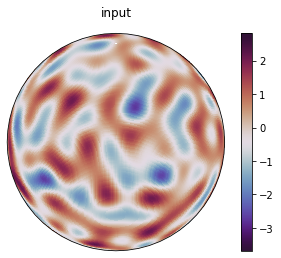

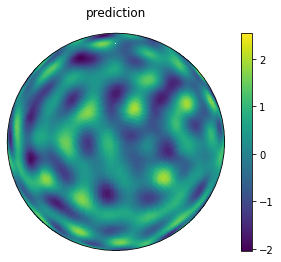

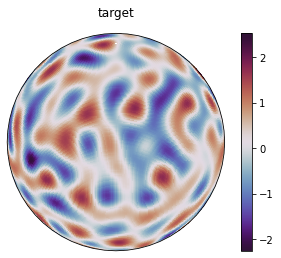

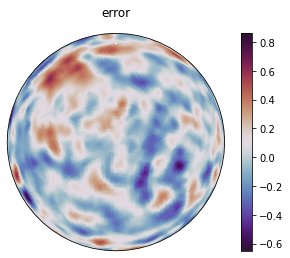

In [13]:
torch.manual_seed(0)

with torch.inference_mode():
    inp, tar = next(iter(dataloader))
    out = model(inp).detach()

s = 0; ch = 0
print( f'Input shape: {inp.shape}, Output shape: {out.shape}, type = {type(inp)} ')
input_image = inp[s, ch]
vmin, vmax = torch.min(input_image), torch.max(input_image)

fig = plt.figure()
im = gridops.plot_griddata(input_image, fig, projection='3d', title='input', vmin=vmin, vmax=vmax )
plt.colorbar(im)
plt.show()

fig = plt.figure()
im = gridops.plot_griddata(out[s, ch], fig, projection='3d', title='prediction', vmin=vmin, vmax=vmax )
plt.colorbar(im)
plt.show()

fig = plt.figure()
im = gridops.plot_griddata(tar[s, ch], fig, projection='3d', title='target', vmin=vmin, vmax=vmax )
plt.colorbar(im)
plt.show()

fig = plt.figure()
im = gridops.plot_griddata((tar-out)[s, ch], fig, projection='3d', title='error', vmin=vmin, vmax=vmax )
plt.colorbar(im)
plt.show()